In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/drive/')

Drive already mounted at /drive/; to attempt to forcibly remount, call drive.mount("/drive/", force_remount=True).


In [ ]:
img = np.load("/drive/My Drive/ML Data/UTKFaceData/Image_Preprocessed.npy")

In [ ]:
Y = np.load("/drive/My Drive/ML Data/Age.npy")
print(Y.shape)

(23708, 1)


In [ ]:
Y = Y.astype(np.uint8)
y = Y.ravel()

In [ ]:
Y_final = []
for age in y:
  if age < 15:
    Y_final.append(0)           # Child
  elif age < 25:
    Y_final.append(1)           # Young age
  elif age < 40:
    Y_final.append(2)           # Middle age
  elif age < 70:
    Y_final.append(3)           # Adults
  elif age >= 70:
    Y_final.append(4)           # Old age


In [ ]:
import cv2
import matplotlib.pyplot as plt

# Building Gabor Filters for coloured images.

def build_filters():
   filters = []
   ksize = 31
   for theta in np.arange(0, np.pi, np.pi / 16):
       for lambdat in np.arange(10,11,12):
           for gamma in np.arange(0.5,1,3):
                   kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lambdat, gamma, 0, ktype=cv2.CV_32F)
                   kern /= 1.5*kern.sum()
                   filters.append(kern)
   return filters

 
def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum


The image before Gabor is applied


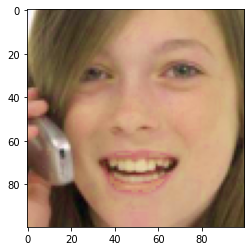

In [ ]:
print("The image before Gabor is applied")
rand_img = cv2.cvtColor(img[987], cv2.COLOR_BGR2RGB)
plt.imshow(rand_img)
plt.show()

In [ ]:
filters = build_filters()

for i in range(0,23708):
  img[i] = process(img[i], filters) 

The image after Gabor is applied


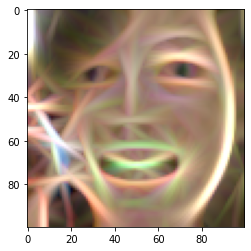

In [ ]:
print("The image after Gabor is applied")
rand_img = cv2.cvtColor(img[987], cv2.COLOR_BGR2RGB)
plt.imshow(rand_img)
plt.show()

In [ ]:
print(img.shape)

(23708, 100, 100, 3)


In [ ]:
X_color = img.reshape(23708,30000)

In [ ]:
del img
del filters

Now loading the grey dataset.

In [ ]:

grey = np.load("/drive/My Drive/ML Data/UTKFaceData/Grey_Preprocessed.npy")
print(grey.shape, grey.dtype)

(23708, 100, 100) uint8


In [ ]:
for i in range(0,23708):
  
  b1 = cv2.GaussianBlur(grey[i], (1,1), 3)
  b2 = cv2.GaussianBlur(grey[i], (3,3), 3)
  grey[i] = b1 - b2                                       # Applying DoG ( Difference of Guassian )
  

In [ ]:
print(grey.shape)

(23708, 100, 100)


In [ ]:
X_grey = grey.reshape(23708,10000)

In [ ]:
print(X_grey.shape)

(23708, 10000)


In [ ]:
X_final = np.concatenate((X_color, X_grey), axis=1)
print(X_final.shape)

(23708, 40000)


In [ ]:
del grey
del X_color
del X_grey

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

(array([3651.,    0.,    0., 3252.,    0.,    0.,    0., 9571.,    0.,
           0.,    0., 5862.,    0.,    0., 1372.]),
 array([0.        , 0.26666667, 0.53333333, 0.8       , 1.06666667,
        1.33333333, 1.6       , 1.86666667, 2.13333333, 2.4       ,
        2.66666667, 2.93333333, 3.2       , 3.46666667, 3.73333333,
        4.        ]),
 <a list of 15 Patch objects>)

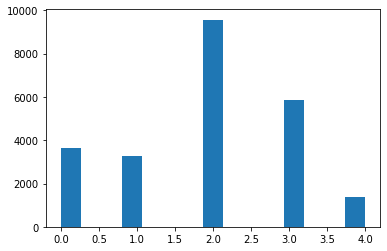

In [ ]:
# checking the distribution of labels.
plt.hist(Y_final, bins=15)

Before providing the X_final, the two different datasets would be concatenated and their labels would also be checked.

After the split, we will seperate them again

In [ ]:
Y_final = np.array(Y_final, dtype = np.uint8)

In [ ]:
print(Y_final.shape)

(23708,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final,Y_final,test_size=0.2, random_state=30)

In [ ]:
del X_final, Y_final

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train.dtype, X_test.dtype, y_train.shape, y_test.shape)

(18966, 40000) (4742, 40000) (18966,) (4742,)
uint8 uint8 (18966,) (4742,)


Now, the Grey Images will be applied with LDA
Then the 2 models will be trained using any method that I find fast. 
Later on, the 2 will be stacked and thus probability distribution will form.

In [ ]:
'''sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
'''

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=4)
X_train_final = lda.fit_transform(X_train, y_train)
del X_train

In [ ]:
X_test_final = lda.transform(X_test)
del X_test

In [ ]:
'''from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_final, y_train)
'''

In [ ]:
#y_pred = clf.predict(X_test)